### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../../')
from Modules.Basics import *
from Modules.Class_Basics import *

from scipy.stats import ks_2samp

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [2]:
dirLoc = '../../Data/'

In [45]:
def getCuts(nJets):
    valData = h5py.File(dirLoc + 'val_' + str(nJets) + '.hdf5', "r+")
    valframe = convertToDF(valData)
    bests = foldAMSScan(valframe, 3)

In [46]:
getCuts(1)

15509 candidates loaded
[0.8658062815666199, 0.8044665963302593]
Fold 0, best AMS 0.80446659633 at cut of 0.865806281567. Total weights Signal:Bkg. 13.1761512756:6440.93261719
[0.96745765209198, 0.8709462479439436]
Fold 1, best AMS 0.870946247944 at cut of 0.967457652092. Total weights Signal:Bkg. 13.7186861038:6527.53613281
[0.9598258137702942, 0.984161795969062]
Fold 2, best AMS 0.984161795969 at cut of 0.95982581377. Total weights Signal:Bkg. 13.2614688873:6400.92626953
Mean cut 0.9280973880451805 mean AMS 0.8804549740348823


In [47]:
cuts = [0.974683394325156,
        0.9280973880451805,
        0.9617854822776671]

In [48]:
def saveTest(cuts, name):
    data = pandas.DataFrame()
    
    for i, cut in enumerate(cuts):
        tmp = pandas.DataFrame()
        testData = h5py.File(dirLoc + 'testing_' + str(i) + '.hdf5', "r")
        
        tmp['EventId'] = getFeature('EventId', testData)
        tmp['pred_class'] = getFeature('pred', testData)
    
        tmp['Class'] = 'b'
        tmp.loc[tmp.pred_class >= cut, 'Class'] = 's'
        
        data = data.append(tmp, ignore_index = True)

    data.sort_values(by=['pred_class'], inplace=True)
    data['RankOrder']=range(1, len(data)+1)
    data.sort_values(by=['EventId'], inplace=True)

    print dirLoc + name + '_test.csv'
    print len(data), len(list(set(data['EventId'])))
    data.to_csv(dirLoc + name + '_test.csv', columns=['EventId', 'RankOrder', 'Class'], index=False)

In [49]:
def plotSplitDist(cut, nJets):
    test = pandas.DataFrame()
    testData = h5py.File(dirLoc + 'testing_' + str(nJets) + '.hdf5', "r")

    test['pred_class'] = getFeature('pred', testData)

    test['Class'] = 'b'
    test.loc[test.pred_class >= cut, 'Class'] = 's'
    
    val = pandas.DataFrame()
    valData = h5py.File(dirLoc + 'val_' + str(nJets) + '.hdf5', "r")

    val['pred_class'] = getFeature('pred', valData)

    val['Class'] = 'b'
    val.loc[val.pred_class >= cut, 'Class'] = 's'
    
    print "signal agreement:", ks_2samp(test[test.Class == 's']['pred_class'], val[val.Class == 's']['pred_class'])[1]
    print "background agreement:", ks_2samp(test[test.Class == 'b']['pred_class'], val[val.Class == 'b']['pred_class'])[1]
    
    getClassPredPlot([test[test.Class == 's'], test[test.Class == 'b'],
                      val[val.Class == 's'], val[val.Class == 'b']], 
                     labels=['Testing Bkg', 'Testing Sig', 'Val Bkg', 'Val Sig'])

In [50]:
def plotDist(cuts):
    test = getData(cuts, 'testing')
    val = getData(cuts, 'val')
    
    print "signal agreement:", ks_2samp(test[test.Class == 's']['pred_class'], val[val.Class == 's']['pred_class'])[1]
    print "background agreement:", ks_2samp(test[test.Class == 'b']['pred_class'], val[val.Class == 'b']['pred_class'])[1]
    
    getClassPredPlot([test[test.Class == 's'], test[test.Class == 'b'],
                      val[val.Class == 's'], val[val.Class == 'b']], 
                     labels=['Testing Bkg', 'Testing Sig', 'Val Bkg', 'Val Sig'])

In [51]:
def getData(cuts, mode):
    data = pandas.DataFrame()
    
    for i, cut in enumerate(cuts):
        tmp = pandas.DataFrame()
        datafile = h5py.File(dirLoc + mode + '_' + str(i) + '.hdf5', "r+")
        
        tmp['pred_class'] = getFeature('pred', datafile)
        
        if mode == 'val':
            tmp['gen_target'] = getFeature('targets', datafile)
            tmp['gen_weight'] = getFeature('weights', datafile)
    
        tmp['Class'] = 'b'
        tmp.loc[tmp.pred_class >= cut, 'Class'] = 's'
        
        data = data.append(tmp, ignore_index = True)

    return data

##  Validation data

In [52]:
valData = getData(cuts, 'val')

In [53]:
AMS(np.sum(valData[(valData.gen_target == 1) & (valData.Class == 's')]['gen_weight']), np.sum(valData[(valData.gen_target == 0) & (valData.Class == 's')]['gen_weight']))

1.5298039684856013

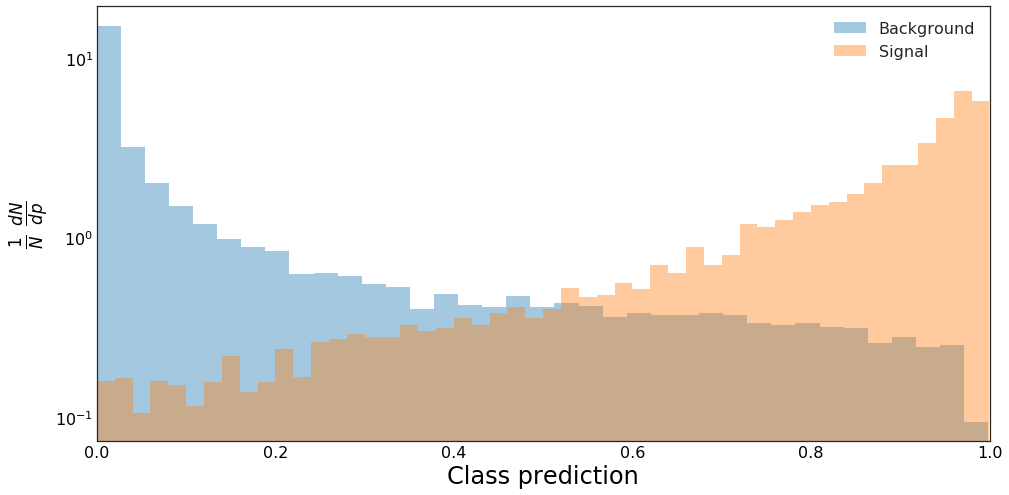

In [12]:
getClassPredPlot([valData[(valData.gen_target == 0)], valData[(valData.gen_target == 1)]], weightName='gen_weight')

##  Testing data

signal agreement: 0.4063534325238858
background agreement: 0.09547704715241058


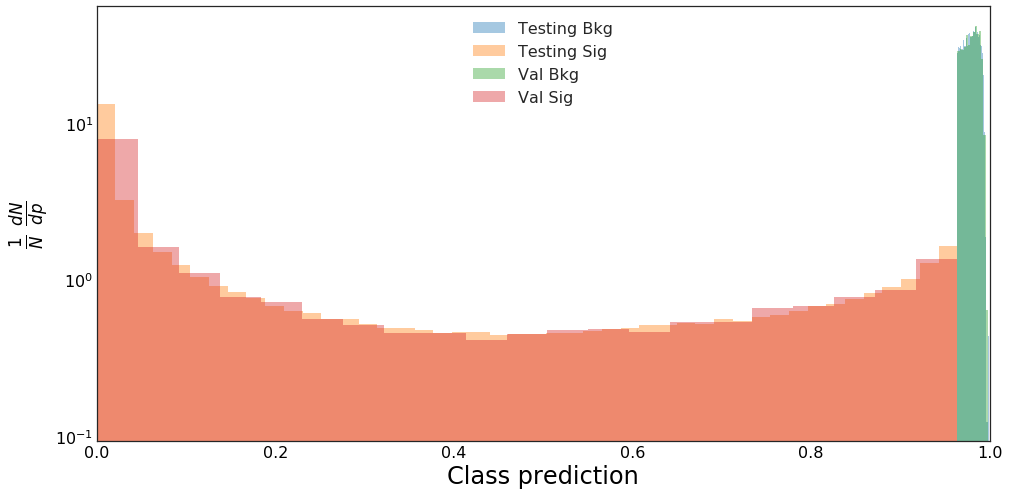

signal agreement: 0.47332127052199724
background agreement: 0.7182687629733376


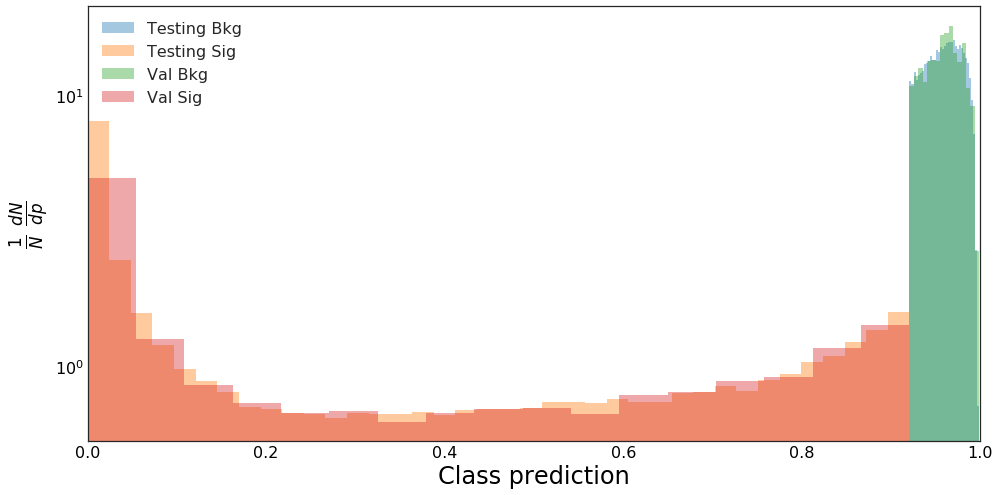

signal agreement: 0.439732727728464
background agreement: 0.7565879159779384


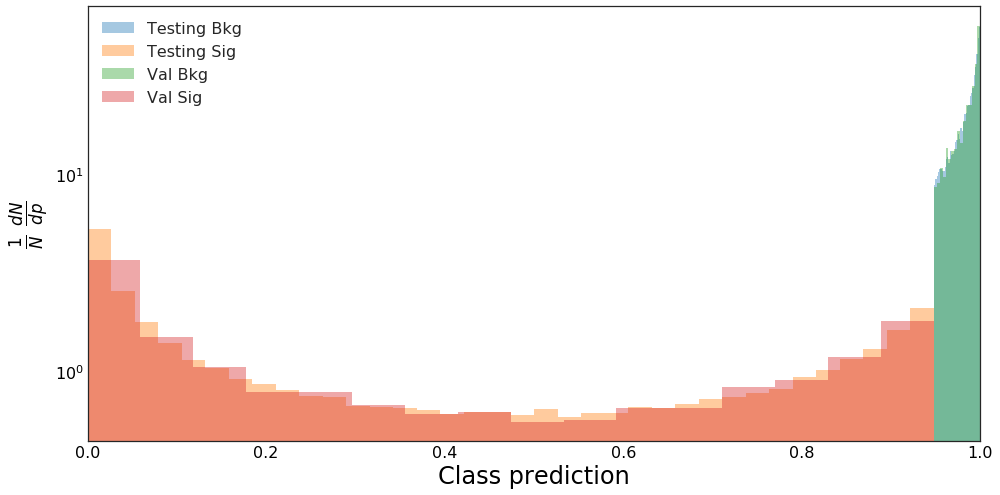

In [13]:
for i, cut in enumerate(cuts):
    plotSplitDist(cut, i)

signal agreement: 0.7312989092602568
background agreement: 0.12695567830846033


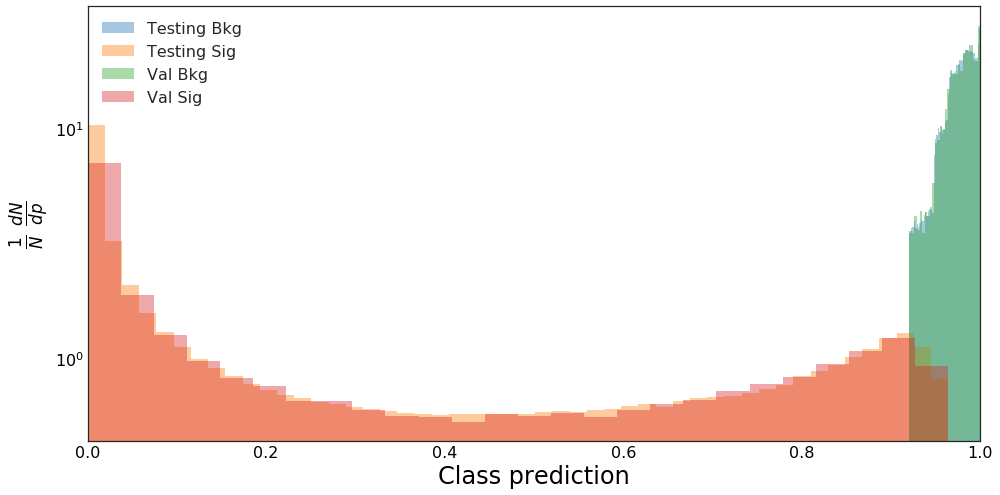

In [14]:
plotDist(cuts)

In [15]:
saveTest(cuts, 'SplitJets')

../../Data/SplitJets_test.csv
550000 550000


In [16]:
!kaggle competitions submit -c higgs-boson -f ../../Data/SplitJets_test.csv -m"Day3 redux"

Successfully submitted to Higgs Boson Machine Learning Challenge